# Tumor Analysis of Patient S1

Import Necessary Packages/Libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, preprocessing

### Functions to process data

create_rdr_baf(self) is a function that selects the columns of interest for RDR and BAF by concatenating the chromosome, start, and end numbers into a single column and pivoting the data from long to wide. After the RDR and BAF are pivoted individually, they are inner-merged to create a new dataframe. This allows for easier analysis as the cell sequence is identified as the index with RDR and BAF inputs for the columns.

In [2]:
def create_rdr_baf(self):
    print(self['CELL'].unique().shape[0])
    crdr = self[['#CHR', 'START', 'END', 'CELL', 'RDR']] #Selects columns of interest for RDR
    
    pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    crdr['#CHR']= crdr['#CHR'].astype(str) 
    crdr['START']= crdr['START'].astype(str)
    crdr['END']= crdr['END'].astype(str)

    crdr["chr_start_end"]= crdr['#CHR'] + '_' + crdr["START"]+ '_' + crdr['END']  #Concatenates columns

    crdr = crdr.pivot(index='CELL', columns='chr_start_end', values='RDR')   #Pivots data from long to wide
    #print(crdr.shape)
    baf = self[['#CHR', 'START', 'END', 'CELL', 'BAF']] #Selects columns of interest for BAF

    pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    baf['#CHR']= baf['#CHR'].astype(str) 
    baf['START']= baf['START'].astype(str)
    baf['END']= baf['END'].astype(str)

    baf["chr_start_end"]= baf['#CHR'] + '_' + baf["START"]+ '_' + baf['END']  #Concatenates columns

    baf = baf.pivot(index='CELL', columns='chr_start_end', values='BAF')   #Pivots data from long to wide
    #print(baf.shape)
    x = crdr.merge(baf, how='inner', on='CELL')  #Concatenates columns
    #print(x.shape)
    return x

reformat(r) is a function that allows us to adjust the structure of our rows and columns within the dataset. This step is crucial for further analysis and comparisons.

In [5]:
def reformat(r):
    rnew = np.empty(r.shape, dtype='U25')
    for i,val in enumerate(r):
        new_string = f"{val[0]}_{val[1]}_{val[2]}"    
        new_string = new_string.replace('chr', '')
        rnew[i] = new_string
    return rnew

### Read in process data

Read all the files from PatientS0 into a dictionary

In [6]:
datA = pd.read_csv("patientS0/calls/sectionA/calls.tsv.gz", sep="\t", compression="gzip" )
datB = pd.read_csv("patientS0/calls/sectionB/calls.tsv.gz", sep="\t", compression="gzip" )
datC = pd.read_csv("patientS0/calls/sectionC/calls.tsv.gz", sep="\t", compression="gzip" )
datD = pd.read_csv("patientS0/calls/sectionD/calls.tsv.gz", sep="\t", compression="gzip" )
datE = pd.read_csv("patientS0/calls/sectionE/calls.tsv.gz", sep="\t", compression="gzip" )
data = {'A': datA, 'B': datB,'C': datC,'D': datD,'E': datE}

Read all the files from PatientS1 into a dictionary

In [7]:
datA1 = pd.read_csv("patientS1/calls/sectionA1/calls.tsv.gz", sep="\t", compression="gzip" )
datA2 = pd.read_csv("patientS1/calls/sectionA2/calls.tsv.gz", sep="\t", compression="gzip" )
datA3 = pd.read_csv("patientS1/calls/sectionA3/calls.tsv.gz", sep="\t", compression="gzip" )
datB1 = pd.read_csv("patientS1/calls/sectionB1/calls.tsv.gz", sep="\t", compression="gzip" )
datB2 = pd.read_csv("patientS1/calls/sectionB2/calls.tsv.gz", sep="\t", compression="gzip" )
datas = {'A1': datA1, 'A2': datA2,'A3': datA3,'B1': datB1,'B2': datB2}

Preprocess the Data with reformat() function and remove 'chr' within the #CHR column. Also, create an intersection to change the amount of columns within the dataframes.

In [8]:
for d in data:
    temp = data[d].copy()
    temps = temp['#CHR'].str.replace('chr', '')
    temp['#CHR'] = temps
    data[d] = temp

In [9]:
datas1 = pd.concat(datas)
datas1 = datas1.set_index(['#CHR', 'START', 'END'])
datas0 = pd.concat(data)
datas0 = datas0.set_index(['#CHR', 'START', 'END'])

In [13]:
s1bins = datas1.index.unique().to_numpy()
s0bins = datas0.index.unique().to_numpy()

In [14]:
reformats0 = reformat(s0bins)
reformats1 = reformat(s1bins)
intersect = np.intersect1d(reformats0, reformats1)
print(intersect.shape)

(544,)


Convert the labels of the dataframe to different datatypes. 

In [16]:
labels = pd.DataFrame(data = intersect 
             , columns = ['label'])
labels[['#CHR','START', 'END']] = labels['label'].str.split('_',expand=True)
labels = labels.drop(columns = ['label'])

convert_dict = {'START' : int, 'END' : int}
labels = labels.astype(convert_dict)

Preprocess the data first by inner-merging the labels into the data on #CHR, START, and END columns. Then, transform the data from wide to long with a column for each RDR and BAF and a row for a each cell. Use "SECTION-BARCODE" as the index.

In [17]:
final = []
total = 0
for d in data:
    data[d] = data[d].merge(labels, how='inner', on=['#CHR', 'START', 'END'])
    x = create_rdr_baf(data[d])
    cell_id = d + "-" + data[d]['CELL'].unique() 
    total += cell_id.shape[0]
    x = x.reset_index()
    x = x.drop(columns=['CELL'])
    x['CELL'] = cell_id
    x = x.set_index("CELL")
    final.append(x)
print("total cells:" + str(total))
result_s0 = pd.concat(final)

2191
2239
1754
1943
2075
total cells:10202


Preprocess the data first by inner-merging the labels into the data on #CHR, START, and END columns. Then, transform the data from wide to long with a column for each RDR and BAF and a row for a each cell. Use "SECTION-BARCODE" as the index. Drop the last two columns of result_s0 and result_s1.

In [21]:
finals = []
totals = 0
for d in datas:
    datas[d]['#CHR'] = datas[d]['#CHR'].astype(str)  
    datas[d] = datas[d].merge(labels, how='inner', on=['#CHR', 'START', 'END'])
    x = create_rdr_baf(datas[d])
    cell_id = d + "-" + datas[d]['CELL'].unique() 
    totals += cell_id.shape[0]
    x = x.reset_index()
    x = x.drop(columns=['CELL'])
    x['CELL'] = cell_id
    x = x.set_index("CELL")
    finals.append(x)               
print("total cells:" + str(totals))
result_s1 = pd.concat(finals)
result_s0 = result_s0.drop(columns=['15_15000000_20000000_x', '15_15000000_20000000_y'])
result_s1 = result_s1.drop(columns=['15_15000000_20000000_x', '15_15000000_20000000_y'])

1311
1233
1311
1019
1153
total cells:6027


### Mapping of Clone Data

Read all the files from Clones into a dictionary

In [22]:
clones1 = pd.read_csv("patientS1/clones/sectionA1/mapping.tsv.gz", sep="\t", compression="gzip")
clones2 = pd.read_csv("patientS1/clones/sectionA2/mapping.tsv.gz", sep="\t", compression="gzip")
clones3 = pd.read_csv("patientS1/clones/sectionA3/mapping.tsv.gz", sep="\t", compression="gzip")
clones4 = pd.read_csv("patientS1/clones/sectionB1/mapping.tsv.gz", sep="\t", compression="gzip")
clones5 = pd.read_csv("patientS1/clones/sectionB2/mapping.tsv.gz", sep="\t", compression="gzip")
clones = {'A1': clones1, 'A2': clones2,'A3': clones3,'B1': clones4,'B2': clones5}

Create columns of section and cell while concatenating the clones into a single dataframe.

In [23]:
em = []
for c in clones:
    temp = clones[c]
    temp['SECTION'] = c
    temp['CELL'] = temp['SECTION'] + '-' + temp['#CELL']
    temp = temp.set_index('CELL')
    em.append(temp)
cloncal = pd.concat(em)

Remove the clones containing None values to reduce errors.

In [24]:
faults = cloncal['CLONE'] == 'None'
faults = cloncal.loc[faults]  #Saves the clones with None values
cloncals = cloncal[cloncal.CLONE != 'None'] #Removes "None" Clones

Identify the normal cells and set their index to the cell.

In [25]:
norm1 = cloncals['CLONE'] == 'Clone68'
norm1 = cloncals.loc[norm1]
norm2 = cloncals['CLONE'] == 'Clone84'
norm2 = cloncals.loc[norm2]
norm3 = cloncals['CLONE'] == 'Clone9'
norm3 = cloncals.loc[norm3]
norm4 = cloncals['CLONE'] == 'Clone6'
norm4 = cloncals.loc[norm4]
norm5 = cloncals['CLONE'] == 'Clone11'
norm5 = cloncals.loc[norm5]
normss = {'t1': norm1, 't2': norm2,'t3': norm3,'t4': norm4,'t5': norm5}
normss = pd.concat(normss, ignore_index=True)
normss['CELL'] = normss['SECTION'] + '-' + normss['#CELL']
normss = normss.set_index('CELL')

Fit and transform our result_s1 data to allow for further analysis and create our x_testfinal dataframe, which we will use to visualize our data.

In [26]:
x_test = fit.transform(result_s1)

x_test = pd.DataFrame(data = x_test #s1
             , columns = ['pca1', 'pca2'])

In [27]:
x_test = x_test.set_index(result_s1.index)
goodcells = x_test.index.difference(faults.index)
x_testfinal = x_test.loc[goodcells]
normss["TYPE"] = "normal"
x_testfinal = x_testfinal.join(normss, how="left") #normas will be x_test when this works
x_testfinal = x_testfinal.fillna({"TYPE":"tumor"})
x_testfinal = x_testfinal.drop(columns=['#CELL', 'CLUSTER', 'CLONE', 'SECTION'])

### Visualization of Tumor Analysis

Visualize scatterplot for all cells with each point colored by cell type.

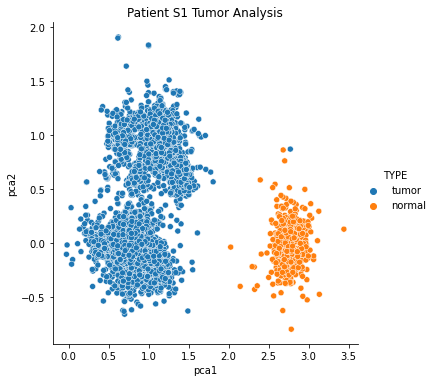

In [30]:
sns.relplot(x = 'pca1', y = 'pca2', hue='TYPE',data=x_testfinal).set(title='Patient S1 Tumor Analysis')